In [15]:
# Test performance of quality control measures on slides
import sys
from pathlib import Path
from itertools import product
import random
from collections import deque
import pytest
import numpy as np
import openslide
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import remove_small_objects
sys.path.extend(['../../', '../../base/', '../../base/options/*', '../../base/data/*'])
import base.data as data
from base.utils import utils
import base.options as options
random.seed(42)

In [2]:
def wsi_file():
    '''Returns an example WSI file path'''
    if utils.on_cluster():
        return '/well/rittscher/projects/TCGA_prostate/TCGA/ff46403a-5498-4ffa-bf85-73afb558eb95/TCGA-J4-A67R-01Z-00-DX1.833DA729-D98E-44F8-A437-1B5BF52071BD.svs'
    elif sys.platform == 'linux':
        return '/home/sedm5660/Documents/Temp/Data/cancer_phenotype/17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi'
    else:
        return '/Users/andreachatrian/Documents/Temp/Data/cancer_phenotype/17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi'

wsi_file = wsi_file()
assert utils.is_pathname_valid(wsi_file)

In [3]:
print(sys.argv)
sys.argv = sys.argv[0:1]  # for jupyter notebook, must remove first two entries
sys.argv.extend([
   '--gpu_ids=-1', 
    '--data_dir=/home/sedm5660/Documents/Temp/Data/cancer_phenotype', 
    '--task=phenotype',
    '--mpp=0.5',
    '--qc_mpp=2.0'
])
print(sys.argv)

['/home/sedm5660/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '-f', '/run/user/1001/jupyter/kernel-b13e0e8f-a943-4c13-afcc-97a13df798ce.json']
['/home/sedm5660/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '--gpu_ids=-1', '--data_dir=/home/sedm5660/Documents/Temp/Data/cancer_phenotype', '--task=phenotype', '--mpp=0.5', '--qc_mpp=2.0']


In [4]:
def apply_options():
    ApplyOptions = options.apply_options.ApplyOptions
    apply_options = ApplyOptions()
    return apply_options
apply_options = apply_options()

In [5]:
opt = apply_options.parse()

----------------- Options ---------------
             aspect_ratio: 1.0                           
                  augment: 0                             
              augment_dir:                               
            augment_level: 0                             
               batch_size: 16                            
          check_tile_blur: False                         
          check_tile_fold: False                         
          checkpoints_dir:                               
            cna_tablefile: /well/rittscher/projects/TCGA_prostate/TCGA/data/prad_tcga_pan_can_atlas_2018/data_CNA.txt
                patch_size: 1024                          
                 data_dir: /home/sedm5660/Documents/Temp/Data/cancer_phenotype	[default: /well/rittscher/projects/TCGA_prostate/TCGA]
              data_fields: case_submitter_id,sample_id,case_id,sample_submitter_id,is_ffpe,sample_type,state,oct_embedded
             dataset_name: tcga                          
   

In [6]:
#save opt for use in extracting patches
data_dir = opt.data_dir
opt.data_dir = '/well/rittscher/projects/TCGA_prostate/TCGA'
import pickle
with open(Path('/mnt/rescomp/projects/TCGA_prostate/TCGA')/'data'/'opt.pkl', 'wb') as opt_file:
    pickle.dump(opt, opt_file)
opt.data_dir = data_dir
print(opt.data_dir)

/home/sedm5660/Documents/Temp/Data/cancer_phenotype


In [7]:
slide = data.wsi_reader.WSIReader(opt, wsi_file)

In [8]:
slide.find_good_locations()
for loc, info in random.sample(list(slide.tile_info.items()), k=min(20, len(slide.locations))):
    print(f'{loc} - {info}')
len(slide.locations)

[Errno 2] No such file or directory: '/home/sedm5660/Documents/Temp/Data/cancer_phenotype/data/quality_control/17_A047-4463_153D+-+2017-05-11+09.40.22.tsv'
133120,38912 - empty
22528,32768 - good
4096,45056 - empty
153600,75776 - empty
57344,12288 - empty
51200,6144 - empty
45056,69632 - empty
28672,22528 - good
153600,32768 - empty
20480,38912 - empty
141312,22528 - empty
153600,67584 - empty
112640,67584 - good
16384,73728 - empty
122880,36864 - empty
88064,16384 - empty
6144,20480 - empty
6144,4096 - empty
18432,47104 - empty
45056,30720 - good


3280

In [9]:
# functions for quality control on histology tiles
def is_HnE_mask(image, threshold=0.5, sat_thresh=30):
    """Returns true if slide contains tissue or just background
    Problem: doesn't work if tile is completely white because of normalization step"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(float)
    # do hue and saturation check
    sat_mean = hsv_image[..., 1].mean()
    empirical = hsv_image.prod(axis=2)  # found by Ka Ho to work
    empirical = empirical/np.max(empirical)*255  # found by Ka Ho to work
    kernel = np.ones((20, 20), np.uint8)
    ret, _ = cv2.threshold(empirical.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx((empirical > ret).astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    mask = remove_small_objects(mask.astype(bool), min_size=image.shape[0]/10)
    return np.logical_and(mask > threshold, np.logical_not(hsv_image[..., 1] < sat_thresh)), empirical, hsv_image

# functions for quality control on histology tiles
def is_HnE(image, threshold=0.5, sat_thresh=30):
    """Returns true if slide contains tissue or just background
    Problem: doesn't work if tile is completely white because of normalization step"""
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(float)
    # saturation check
    sat_mean = hsv_image[..., 1].mean()
    empirical = hsv_image.prod(axis=2)  # found by Ka Ho to work
    empirical = empirical/np.max(empirical)*255  # found by Ka Ho to work
    kernel = np.ones((20, 20), np.uint8)
    ret, _ = cv2.threshold(empirical.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.morphologyEx((empirical > ret).astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    mask = remove_small_objects(mask.astype(bool), min_size=image.shape[0]/10)
    return mask.mean() > threshold and not sat_mean < sat_thresh

(256, 256) 2048


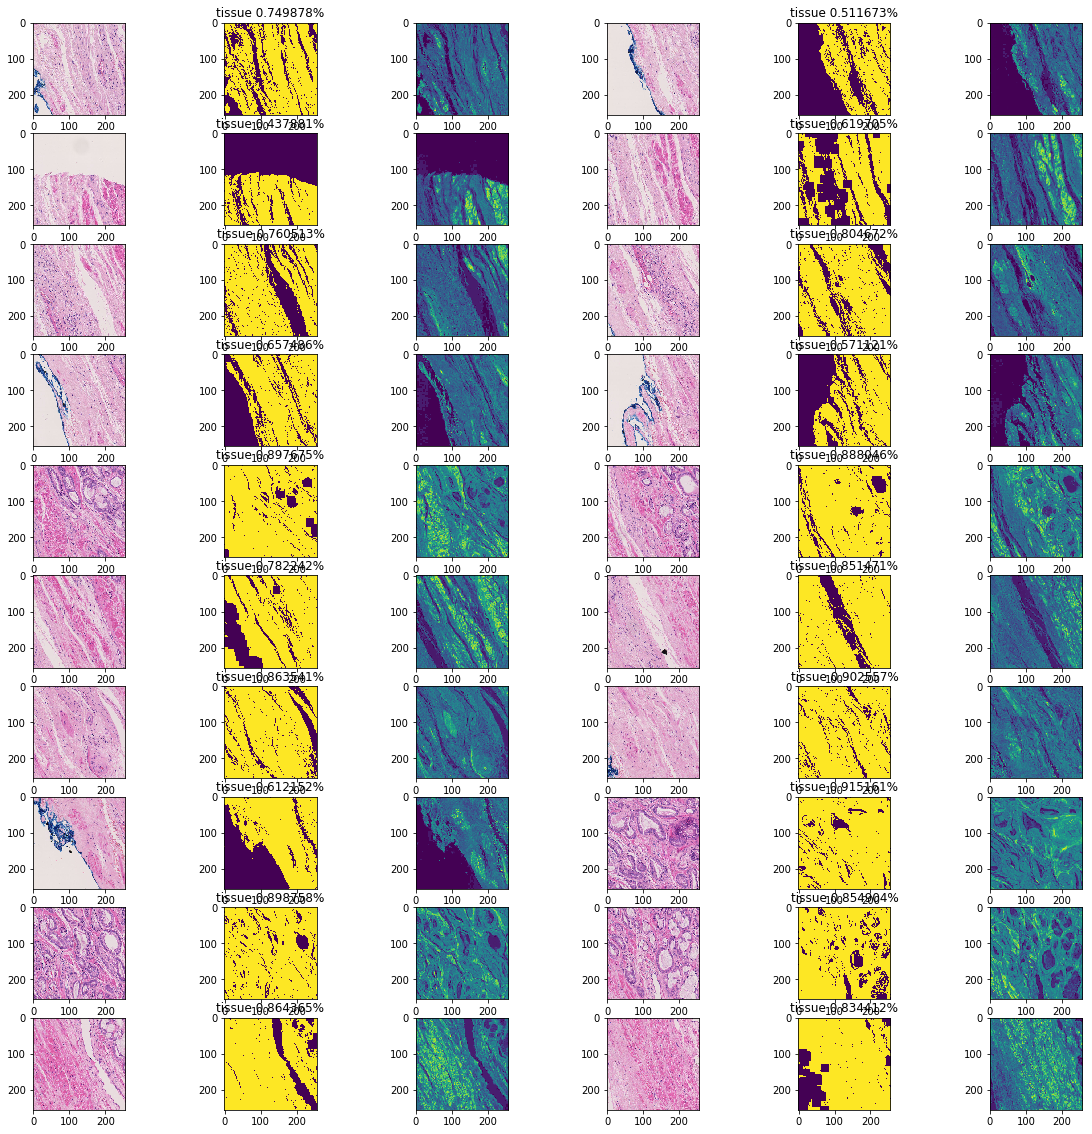

In [10]:
# Calculate qc parameters for slide
qc_downsample = int(slide.level_downsamples[slide.qc_read_level])
read_downsample = int(slide.level_downsamples[slide.read_level])
qc_stride = slide.opt.patch_size * read_downsample  # size of read tiles at level 0
qc_sizes = (qc_stride // qc_downsample,) * 2  # size of read tiles at level qc_read_level
k = min(len(slide.good_locations) - len(slide.good_locations)%2, 20)
#loc_sample = random.sample(slide.locations, k)
loc_sample = slide.good_locations[:k]
fig, axes = plt.subplots(k//2, 3*2, figsize=(20, 20))
axes = axes.reshape((k, 3))
print(qc_sizes, qc_stride)
tiles, masks, empiricals, hsv_images = deque([],len(loc_sample)), deque([],len(loc_sample)), deque([],len(loc_sample)), deque([],len(loc_sample))
for i, (x, y) in enumerate(loc_sample):
    tile = slide.read_region((x, y), slide.qc_read_level, qc_sizes)
    tile = np.array(tile)
    mask, empirical, hsv_image = is_HnE_mask(tile)
    tiles.append(tile); masks.append(mask); empiricals.append(empirical); hsv_images.append(hsv_image)
    axes[i, 0].imshow(tile)
    axes[i, 1].imshow(mask)
    axes[i, 1].set_title('tissue {:2f}%'.format(mask.mean()))
    axes[i, 2].imshow(empirical)

In [11]:
# # Check misclassified
# fig, axes = plt.subplots(1,4)
# idx = 4
# axes[0].imshow(tiles[idx]); axes[1].imshow(masks[idx]); axes[2].imshow(empiricals[idx]); axes[3].imshow(hsv_images[idx])
# print(f'Tile qc result: {is_HnE(tiles[idx], size_wsi=slide.level_dimensions[slide.qc_read_level])}')

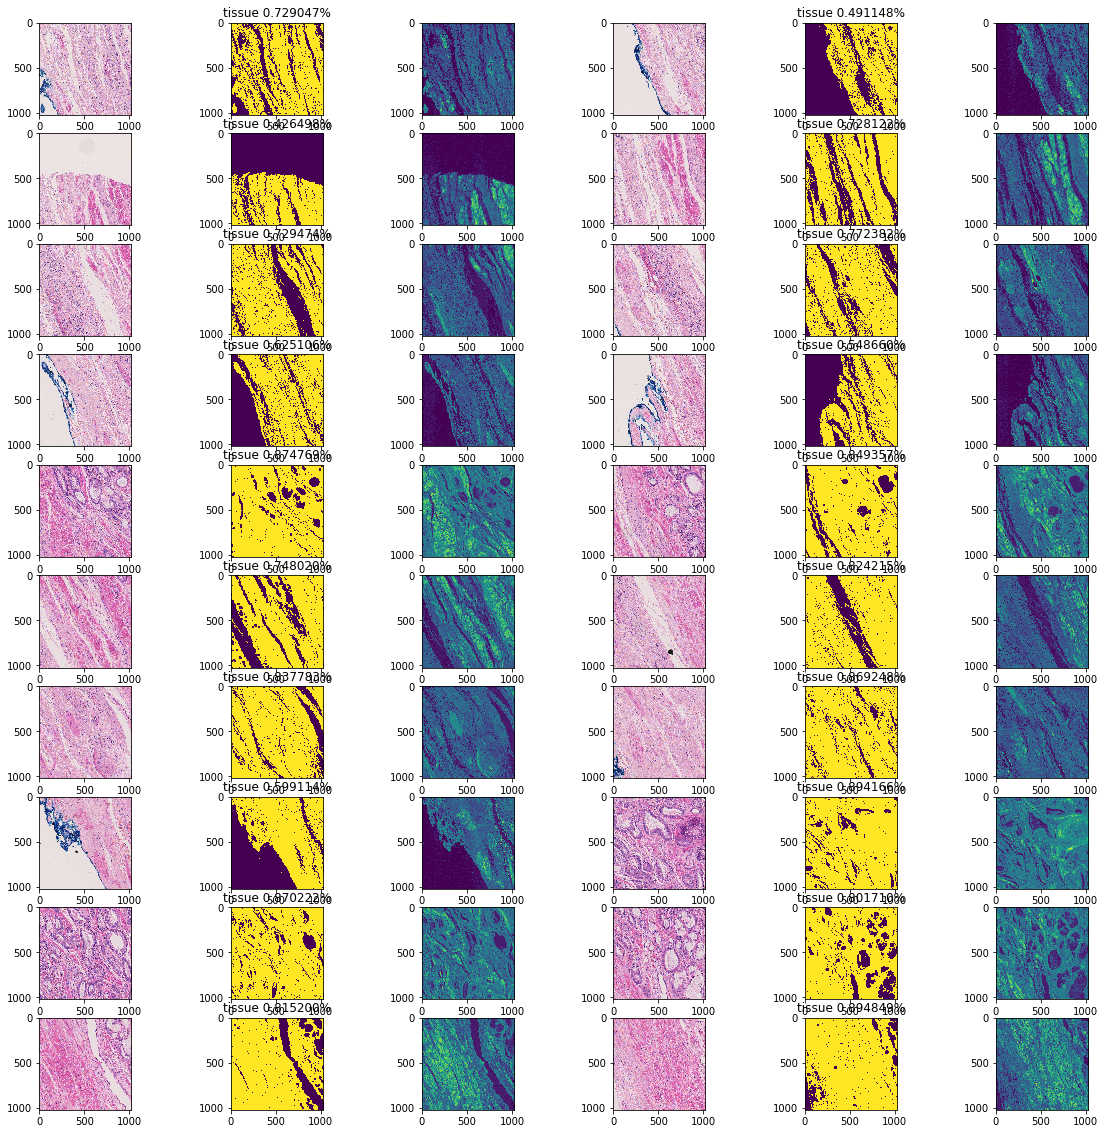

In [12]:
# Show same slides on level 0
k = min(len(slide.good_locations) - len(slide.good_locations)%2, 20)
#loc_sample = random.sample(slide.locations, k)
loc_sample = slide.good_locations[:k]
sizes = (slide.opt.patch_size,) * 2
fig, axes = plt.subplots(k//2, 3*2, figsize=(20, 20))
axes = axes.reshape((k, 3))
tiles, masks, empiricals, hsv_images = deque([],len(loc_sample)), deque([],len(loc_sample)), deque([],len(loc_sample)), deque([],len(loc_sample))
for i, (x, y) in enumerate(loc_sample):
    tile = slide.read_region((x, y), slide.read_level, sizes)
    tile = np.array(tile)
    mask, empirical, hsv_image = is_HnE_mask(tile)
    tiles.append(tile); masks.append(mask); empiricals.append(empirical); hsv_images.append(hsv_image)
    axes[i, 0].imshow(tile)
    axes[i, 1].imshow(mask)
    axes[i, 1].set_title('tissue {:2f}%'.format(mask.mean()))
    axes[i, 2].imshow(empirical)

In [13]:
openslide.PROPERTY_NAME_BACKGROUND_COLOR

'openslide.background-color'

In [14]:
slide.properties

<_PropertyMap {'hamamatsu.AHEX[0]': '7411242AC1036C121834BD0770151838BD066C111C31C109680C102BBD10680D0C2EB90F64110C37B50860120832B50A640B0C2DB5105D01082EB5166C071036B90D640E1C2EB9126C071831BD0F7003242BBD16700A2033BD187901282DC51DC2A8', 'hamamatsu.AHEX[0].fluorescence': '740F2827B4036C111833B1036C131837B10168111833B103640B102BAD0B640B082BA5075C130837A501580F0433A103600B082FA5095903042FA50F68031037A905640B1C2FA90B6803182FAD077000242BB10D7403242FB10D7907242FB50F8D1D', 'hamamatsu.AHEX[0].ploidy': '740F2827B4036C111833B1036C131837B10168111833B103640B102BAD0B640B082BA5075C130837A501580F0433A103600B082FA5095903042FA50F68031037A905640B1C2FA90B6803182FAD077000242BB10D7403242FB10D7907242FB50F8D1D', 'hamamatsu.AHEX[1]': '8012302BC80078142438C1017818243EC50174152833C50470111C32C10874121830BD076C151838BD0368141834B9056C0F1830BD0B6802142FBD12740A2035BD096C142831C10F740B2831C10B7807302DC5127C0C2C33C51480063431C9177FB5', 'hamamatsu.AHEX[1].fluorescence': '8013342BBC0778132837B4037817283BB40574132833B8